In [27]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [28]:
path = "dict.opcorpora.txt"

lemmas = {}
morphs = {}
with open(path, 'r', encoding='utf-8') as f:
    flag = False
    for line in f:
        line = line.strip().split('\t')
        if len(line) == 1:
            flag = True
            continue
        if flag: 
            lemma = line[0].lower()
            morf = line[1].split(',')[0].split(' ')[0].lower()
            flag = False
            i = 0
        if len(line) != 0:
            word = line[0].lower()
            lemmas[word] = lemma
            morphs[word] = morf
        else: 
            continue

In [29]:
# Делим на обучающую и тестовую части
import numpy as np
from sklearn.model_selection import train_test_split 

lemmas_X = list(lemmas.keys())
lemmas_y = list(lemmas.values())
lemmas_train_X, lemmas_test_X, lemmas_train_y, lemmas_test_y = train_test_split(lemmas_X, lemmas_y)
l_train = {}
l_test = {}
for i in range(len(lemmas_train_X)):
    l_train[lemmas_train_X[i]] = lemmas_train_y[i]
for i in range(len(lemmas_test_X)):
    l_test[lemmas_test_X[i]] = lemmas_test_y[i]    

In [30]:
morphs_X = list(morphs.keys())
morphs_y = list(morphs.values())
morphs_train_X, morphs_test_X, morphs_train_y, morphs_test_y = train_test_split(morphs_X, morphs_y)
m_train = {}
m_test = {}
for i in range(len(morphs_train_X)):
    m_train[morphs_train_X[i]] = morphs_train_y[i]
for i in range(len(morphs_test_X)):
    m_test[morphs_test_X[i]] = morphs_test_y[i]    

## Лемматизация 

In [32]:
# ищем максимально возможную длину слова в словаре
max_len = -1
for word in lemmas.keys():
    if len(word) > max_len:
        max_len = len(word)
max_len        

40

#### Подготовка данных 

In [34]:
SOS_token = 0
EOS_token = 1


class Letters:
  
    def __init__(self):
        self.letter2index, self.letter2count = {}, {}
        self.index2letter = {0: "SOS", 1: "EOS"}
        self.n_letters = 2  # Учитываем SOS и EOS, это счётчик для нумерации

    def add_word(self, word):
        for letter in word:
            self.add_letter(letter)

    def add_letter(self, letter):

        if letter not in self.letter2index:
            self.letter2index[letter] = self.n_letters
            self.letter2count[letter] = 1
            self.index2letter[self.n_letters] = letter
            self.n_letters += 1
        else:
            self.letter2count[letter] += 1

In [35]:

def prepare_data(lemmas):
    letters = Letters()  

    print("Counting letters...")
    for w in lemmas.keys():
        letters.add_word(w)
    for l in lemmas.values():    
        letters.add_word(l)

    print("Counted letters:")
    print(letters.n_letters)
    
    return letters, list(lemmas.items())

letters, pairs = prepare_data(l_train)
letters, _ = prepare_data(lemmas)

Counting letters...
Counted letters:
48
Counting letters...
Counted letters:
49


#### Модель 

In [37]:
class EncoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
        

In [38]:
MAX_LENGTH = 40 # ограничение на длину последовательности.

class AttnDecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()

        self.hidden_size, self.output_size = hidden_size, output_size
        self.dropout_p, self.max_length = dropout_p, max_length

        # преобразовываем вход
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # у внимания "двойной" вход, а выход -- 
        # набор скаляров на всю потенциальную длину КОДИРУЕМОГО предложения
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)

        # будем объединять взвешенную сумму выходов кодировщика 
        # и эмбеддинг в один вектор на вход для ячейки GRU 
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)

        # предсказания
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):

        # построили эмбеддинг
        embedded = self.embedding(input).view(1, 1, -1)
        # применили дропаут
        embedded = self.dropout(embedded)

        # применили линейный слой к преобразованному входу и полученному 
        # скрытому состоянию; получили вектор длины max_length
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # домножили выходы кодировщика на веса внимания
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # приклеили полученный вектор к эмбеддингу входа
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # применили нелинейное преобразование
        output = F.relu(output)

        # применили рекуррентную ячейку
        output, hidden = self.gru(output, hidden)

        # применили к выходу софтмакс, чтобы получить очередной токен
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Обучение

In [40]:
def indexes_from_word(letters, word):
    return [letters.letter2index[letter] for letter in word]

def tensor_from_word(letters, word):
    indexes = indexes_from_word(letters, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensor_from_pair(pair):
    input_tensor = tensor_from_word(letters, pair[0])
    target_tensor = tensor_from_word(letters, pair[1])
    return (input_tensor, target_tensor)

In [41]:
teacher_forcing_ratio = 0.7


def train(input_tensor, target_tensor, 
          encoder, decoder, 
          encoder_optimizer, decoder_optimizer, # да, два
          criterion, max_length=MAX_LENGTH):
  
    encoder_hidden = encoder.init_hidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0) # первое измерение -- длина
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    # True, если меньше выбранной "доли срабатываний" `teacher_forcing_ratio`
    use_teacher_forcing = random.random() < teacher_forcing_ratio

    if use_teacher_forcing:
        # Teacher forcing: подставляем истинный токен на всей последовательности
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, # индекс
                decoder_hidden, # скрытое состояния
                encoder_outputs # выходы кодировщика
                )
            # сравниваем выход декодировщика с ИСТИННЫМ тензором (это всегда)
            loss += criterion(decoder_output, target_tensor[di])
            # берём в качестве следующего входа ИСТИННЫЙ тензор --
            decoder_input = target_tensor[di]  # ... это teacher forcing

    else:
        # БЕЗ teacher forcing: собственные предсказания как сл. вход
        for di in range(target_length):

            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # берём самый большой выход софтмакса
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # открепляем от выч. графа
            loss += criterion(decoder_output, target_tensor[di])

            # если предсказали EOS, заканчиваем
            if decoder_input.item() == EOS_token:
                break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [42]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [43]:
import matplotlib.pyplot as plt 
from tqdm import tqdm

def train_iter(encoder, decoder, 
               n_iters, 
               print_every=1000, plot_every=100, 
               learning_rate=0.001):
    
    start = time.time()
    plot_losses = []
    print_loss_total, plot_loss_total = 0, 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensor_from_pair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, 
                     encoder, decoder, 
                     encoder_optimizer, decoder_optimizer, 
                     criterion)
        
        print_loss_total += loss
        plot_loss_total += loss

#         if iter % print_every == 0:
#             print_loss_avg = print_loss_total / print_every
#             print_loss_total = 0
#             print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
#                                          iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            # сохраняем средний лосс с прошлого момента измерения
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0


    plt.plot([i for i in range(len(plot_losses))], plot_losses)

100%|██████████| 150000/150000 [3:29:04<00:00, 11.96it/s]  


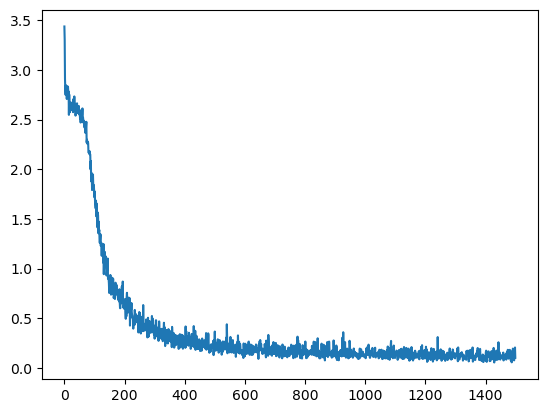

In [44]:
device='cuda' if torch.cuda.is_available() else 'cpu'
hidden_size = 256
encoder1 = EncoderRNN(letters.n_letters, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, letters.n_letters, dropout_p=0.3).to(device)

train_iter(encoder1, attn_decoder1, 150000, print_every=1000)

#### Валидация

In [46]:
def evaluate(encoder, decoder, word, max_length=MAX_LENGTH):

    with torch.no_grad():

        input_tensor = tensor_from_word(letters, word)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        # сохраняем для последующего анализа
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):

            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # раз
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                # два
                decoded_words.append(letters.index2letter[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [47]:
for word in list(l_test.keys())[0:15]:
    pred = evaluate(encoder1, attn_decoder1, word, max_length=MAX_LENGTH)[0]
    lemma = ''
    for l in pred:
        if l != '<EOS>':
            lemma += l
    print(word, lemma)

багатюке багатюк
перераспределялись перераспределяюсь
сильнодеформируемым сильнодеформируемый
спрайтам спраю
отмучившемуся отмучившийся
рецикла рецикла
усадебна усадебна
ремитировано ремитирован
посушившись посушившись
маврскою маврский
сахалинглавснабы сахалинглавсаб
надрёберный надрёберный
гипергамиях гипергамия
пробурив пробурив
приищись приищись


In [48]:
def lemmatize(mystr):
    mylemmas = []
    mystr = mystr.lower()
    words = mystr.strip().split(' ')
    for word in words:
        pred = evaluate(encoder1, attn_decoder1, word, max_length=MAX_LENGTH)[0]
        lemma = ''
        for l in pred:
            if l != '<EOS>':
                lemma += l

        mylemmas.append(lemma)
    return ' '.join(mylemmas)
mystr = 'кофейника прицепом вознессенная стучковой фасоли'
print(f'{mystr} --> {lemmatize(mystr)}')

кофейника прицепом вознессенная стучковой фасоли --> кофейник прицеп вознессенный стучковый фасоль


## Частеречная разметка

In [50]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

m2idx = {}
for val in morphs.values():
    if val not in m2idx:
        m2idx[val] = len(m2idx)
        
idx2m = {v:k for (k,v) in m2idx.items()}

In [51]:
idx2m

{0: 'noun',
 1: 'advb',
 2: 'adjf',
 3: 'adjs',
 4: 'comp',
 5: 'verb',
 6: 'prts',
 7: 'infn',
 8: 'prtf',
 9: 'grnd',
 10: 'prep',
 11: 'prcl',
 12: 'conj',
 13: 'intj',
 14: 'pred',
 15: 'numr',
 16: 'npro'}

In [52]:
morphs_X = list(morphs.keys())
morphs_y = [m2idx[m] for m in list(morphs.values())]
morphs_train_X, morphs_test_X, morphs_train_y, morphs_test_y = train_test_split(morphs_X, morphs_y)


In [110]:
from gensim.models import FastText

model = FastText(vector_size=220, window=3, min_count=1)
model.build_vocab(corpus_iterable=morphs_train_X[:100000])
model.train(corpus_iterable=morphs_train_X[:100000], total_words=len(morphs_train_X[:100000]), epochs=500)

(111579035, 569557000)

In [111]:
model.wv['еж']

array([ 3.47858673e-04, -1.57573924e-03, -5.96463680e-04, -1.48247404e-03,
       -8.92188691e-04, -2.02966083e-04,  1.30654359e-03, -9.78550292e-04,
       -2.81875650e-03, -2.42081573e-04, -6.61555212e-04, -3.43250431e-04,
       -2.55993305e-04, -4.52747568e-04,  1.92958349e-03,  2.87829689e-03,
       -9.87141029e-05,  3.15831392e-03, -4.68043145e-04, -2.07579019e-03,
        9.11853567e-04, -1.80355913e-03, -8.32746562e-04, -2.58494657e-03,
        1.01359806e-03,  2.77216011e-03,  4.62113559e-04,  1.03912328e-03,
        2.50834040e-04,  7.77602720e-04,  9.06168076e-04,  4.80990886e-04,
       -6.59207173e-04, -9.91474022e-04, -3.57801073e-05,  2.82016955e-03,
       -1.47267361e-04, -2.11666408e-03, -2.88496423e-03, -8.14319297e-04,
       -2.58089718e-03, -1.53486675e-03,  4.58186347e-04,  7.45438796e-04,
        4.92329302e-04, -2.17611901e-03,  2.27614233e-04,  1.50082202e-03,
       -1.92105304e-03,  2.67914333e-03, -1.62157824e-03,  1.11578917e-03,
        5.58314729e-04,  

In [112]:
import torch.utils.data as data_utils
X_train = [model.wv[word] for word in morphs_train_X]
X_test = [model.wv[word] for word in morphs_test_X]

inputs_train = torch.tensor(X_train[:100000])
targets_train = torch.IntTensor(morphs_train_y[:100000])

inputs_test = torch.tensor(X_test)
targets_test = torch.IntTensor(morphs_test_y)

train = data_utils.TensorDataset(inputs_train, targets_train)
test = data_utils.TensorDataset(inputs_test, targets_test)

trainset = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=16, shuffle=False)

In [113]:
class MorphNet(nn.Module):
    def __init__(self):
        super().__init__()  #вх. #вых.
        self.fc1 = nn.Linear(220, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 17)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

net = MorphNet()
print(net)

MorphNet(
  (fc1): Linear(in_features=220, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=17, bias=True)
)


100%|██████████| 40/40 [25:07<00:00, 37.68s/it]


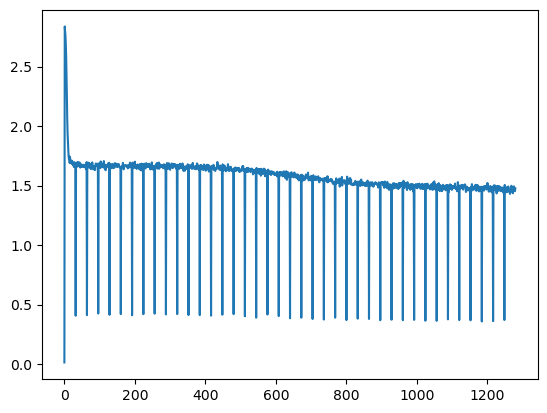

In [114]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, StepLR
plot_every=200
loss_function = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00003)
scheduler = StepLR(optimizer, 0.00003, gamma=0.9)

plot_loss_total = 0
plot_losses = []
for epoch in tqdm(range(40)): 
    for iter, data in enumerate(trainset):
        X, y = data  
        net.zero_grad()
        output = net(X.float()) 
        
        loss = loss_function(output, y.long())
        plot_loss_total += loss
        loss.backward()  
        optimizer.step() 
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            # сохраняем средний лосс с прошлого момента измерения
            plot_losses.append(plot_loss_avg.detach().numpy())
            plot_loss_total = 0
plt.plot([i for i in range(len(plot_losses))], plot_losses)  

In [115]:
def eval(testset):
    ans = []
    res = []
    with torch.no_grad():
        for batch in tqdm(testset):
            X, y = batch    
            output = net(torch.FloatTensor(X))
            for i in range(len(y)):
                res.append(torch.argmax(output[i]).item())
            ans += y    
    return res, ans

def eval_on_single_word(word):
    with torch.no_grad():
        X = model.wv[word] 
        y = morphs[word] # true morph
        output = net(torch.FloatTensor(X))
        predict = torch.argmax(output).item()
        res = idx2m[predict]        
    return word, y, res

In [116]:
for i in range(20):
    word, y, res = eval_on_single_word(morphs_test_X[i])
    print(f'{word}, {y} --> {res}')

прохромосома, noun --> prtf
ямбе, noun --> prtf
окрепну, verb --> noun
стофутовому, adjf --> noun
переодевающих, prtf --> prtf
оговорить, infn --> prtf
обшаркайте, verb --> noun
бечёвочные, adjf --> prtf
сучимую, prtf --> prtf
детерминирующие, prtf --> noun
крупнорассечённую, adjf --> prtf
прорезывавшейся, prtf --> prtf
закругляйся, verb --> prtf
недесятичные, adjf --> prtf
баварцах, noun --> noun
пакибытью, noun --> noun
удосуживайся, verb --> prtf
отсечениях, noun --> noun
новозыковским, adjf --> noun
патронатам, noun --> noun


100%|██████████| 1000/1000 [00:01<00:00, 847.56it/s]


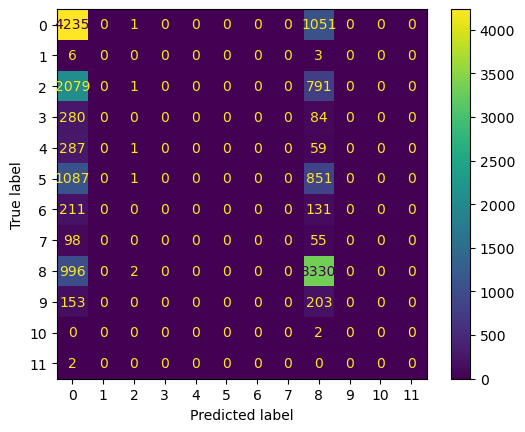

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
res, ans = eval(list(testset)[:1000])
c = confusion_matrix(ans, res)
disp = ConfusionMatrixDisplay(c)
disp.plot()

## Собираем все вместе

In [119]:
import string 
def markup(sentence):
    # убираем из предложения пунктуацию
    sent = ''
    for char in sentence:
        if char not in string.punctuation:
            sent += char
    outputs = []
    
    words = sent.lower().strip().split() # приводим к нижнему регистру и разбиваем на слова
    for word in words: # для каждого слова
        # предсказываем лемму
        pred = evaluate(encoder1, attn_decoder1, word, max_length=MAX_LENGTH)[0]
        lemma = ''
        for l in pred:
            if l != '<EOS>':
                lemma += l
        # предсказываем часть речи 
        with torch.no_grad():
            X = model.wv[word] 
            output = net(torch.FloatTensor(X))
            predict = torch.argmax(output).item()
            morph = idx2m[predict]        
        out = (word, lemma, morph)
        outputs.append(out)    
    return outputs

def prettify(sentence):
    print_sentence = sentence + '--> '
    outputs = markup(sentence)
    for out in outputs:
        word, lemma, morph = out
        print_sentence += f'{word}{{ {lemma}={morph} }} '
    print(print_sentence)    

In [120]:
prettify("В каждом маленьком ребенке, и в мальчишке, и в девчонке, есть по двести грамм взывчатки!")

В каждом маленьком ребенке, и в мальчишке, и в девчонке, есть по двести грамм взывчатки!--> в{ вал=prtf } каждом{ каждо=prtf } маленьком{ маленький=noun } ребенке{ ребенка=prtf } и{ =prtf } в{ вал=prtf } мальчишке{ мальчишка=noun } и{ =prtf } в{ вал=prtf } девчонке{ девчонка=noun } есть{ есть=noun } по{ пол=prtf } двести{ двесть=noun } грамм{ граммал=noun } взывчатки{ взывчатка=prtf } 
